# Aprendizaje Automático


El objetivo de este práctico es afianzar los conocimientos adquiridos hasta este momento, haciendo un proceso de re-análisis de los datos para encarar desde distintas perspectivas (selección de features, redefinición de clases y subclases) para conseguir nuevos resultados sobre los modelos ya trabajados, añadiendo ensemble learning al análisis.

La idea es aprender a iterar en el proceso de ciencia de datos, no quedandonos con los resultados obtenidos del primer proceso realizado.

# Enunciado del práctico

Se les da la libertad de hacer los análisis que consideren necesarios en base a lo ya aprendido, encarando el problema desde distintos puntos de vista sobre todo en el proceso de los datos. para generar perspectivas diferentes que amplíen desde la investigación los resultados ya obtenidos.

Generar un informe del enfoque que se tomó y cuales son las conclusiones a las que se arribó.

Se pide también que sumen aquellos algoritmos en la medida de lo posible (por la cantidad de datos) que se aprendieron en esta materia.



In [1]:
import sys
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
import string
import collections
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics
from wordcloud import WordCloud

In [2]:
# Se verfica entorno de ejecución
in_colab = "google.colab" in sys.modules

if in_colab:
    from google.colab import drive

    drive.mount("/content/drive")
    BASE_DIR = "/content/drive/My Drive/Diplo2020 Mentoria/"
else:
    BASE_DIR = "../"

# Archivos a importar

In [3]:
def txt_to_text(path):
    filepath = open(path, encoding='utf-8')
    text = filepath.read()
    filepath.close()
    return text

In [4]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = dirName + '/' + entry
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [5]:
train_data_dir = BASE_DIR + "Datos/Infoleg"

In [6]:
listOfFile = getListOfFiles(train_data_dir)
print('Cantidad de archivos a importar:', len(listOfFile))    

Cantidad de archivos a importar: 2500


In [7]:
corpus = []
i = 0
for file in listOfFile:
    if file.endswith(".txt"):
        corpus.append([i, file, txt_to_text(file)])
        i = i+1

In [8]:
df_corpus = pandas.DataFrame(corpus,columns=['ID','FILE','TEXTO'])
df_corpus.head()

,ID,FILE,TEXTO
0,0,../Datos/Infoleg/100016.txt,ACUERDOS\nLey 25.939\nApruébase el Acuerdo Sob...
1,1,../Datos/Infoleg/100025.txt,MINISTERIO DE ECONOMIA Y PRODUCCION\nDecisión ...
2,2,../Datos/Infoleg/100026.txt,Secretaría de Hacienda\nPRESUPUESTO\nResolució...
3,3,../Datos/Infoleg/100027.txt,Ministerio de Economía y Producción\nREGIMEN S...
4,4,../Datos/Infoleg/100028.txt,Secretaría de Empleo\nPROGRAMA JEFES DE HOGAR\...


# Analizamos una frase de un documento

Analizamos el primer documento para simplificar las pruebas en la limpieza de datos.

In [9]:
texto = df_corpus[0:1].TEXTO[0]
print(df_corpus[0:1].FILE[0])
print(texto)

../Datos/Infoleg/100016.txt
ACUERDOS
Ley 25.939
Apruébase el Acuerdo Sobre Cooperación Minera suscripto en Caracas el 12 de julio de 2000 con la República Bolivariana de Venezuela. Elaboración de programas de Cooperación Científico-Técnica y de Acción. Solución de controversias.
Sancionada: Septiembre 22 de 2004
Promulgada de Hecho: Octubre 18 de 2004
El Senado y Cámara de Diputados de la Nación Argentina reunidos en Congreso, etc. sancionan con fuerza de Ley:
ARTICULO 1º — Apruébase el ACUERDO SOBRE COOPERACION MINERA ENTRE LA REPUBLICA ARGENTINA Y LA REPUBLICA BOLIVARIANA DE VENEZUELA, suscripto en Caracas —REPUBLICA BOLIVARIANA DE VENEZUELA— el 12 de julio de 2000, que consta de TRECE (13) artículos, cuya fotocopia autenticada forma parte de la presente ley.
ARTICULO 2º — Comuníquese al Poder Ejecutivo nacional.
DADA EN LA SALA DE SESIONES DEL CONGRESO ARGENTINO, EN BUENOS AIRES, A LOS VEINTIDOS DIAS DEL MES DE SEPTIEMBRE DEL AÑO DOS MIL CUATRO.
— REGISTRADO BAJO EL Nº 25.939 —
EDUA

Lo primero que tenemos que hacer es dividir el corpus en *tokens*. 

Si utilizamos la función *split()* no obtendremos una división con sentido lingüístico, ya que por ejemplo, no separa los signos de puntuación que se encuentran al final de cada palabra, como las comas (*castellano,*) ó los puntos (*auténtico.*).

Para evitar este inconveniente utilizaremos la librería NLTK. 

La función por defecto es *nltk.word_tokenize()*, pero existe otra llamada *nltk.tokenize.toktok.ToktokTokenizer()*, la cual obtiene mejores resultados en la lengua española (https://github.com/nltk/nltk/issues/1558).

Para observar esto, tomemos como ejemplo una parte del primer doumento:

In [10]:
texto = "Caracas —REPUBLICA BOLIVARIANA DE VENEZUELA— el 12 de julio de 2000, — REGISTRADO BAJO EL Nº 25.939 — EDUARDO O. CAMAÑO. — MARCELO A. GUINLE. — Eduardo D. Rollano. — Juan J. Canals."
print(texto)

Caracas —REPUBLICA BOLIVARIANA DE VENEZUELA— el 12 de julio de 2000, — REGISTRADO BAJO EL Nº 25.939 — EDUARDO O. CAMAÑO. — MARCELO A. GUINLE. — Eduardo D. Rollano. — Juan J. Canals.


Utilizando *word_tokenize*

In [11]:
wt_tokens = [word for word in nltk.tokenize.word_tokenize(texto)]
print('Cantidad de tokens:', len(wt_tokens))
print(wt_tokens)

Cantidad de tokens: 38
['Caracas', '—REPUBLICA', 'BOLIVARIANA', 'DE', 'VENEZUELA—', 'el', '12', 'de', 'julio', 'de', '2000', ',', '—', 'REGISTRADO', 'BAJO', 'EL', 'Nº', '25.939', '—', 'EDUARDO', 'O.', 'CAMAÑO', '.', '—', 'MARCELO', 'A.', 'GUINLE', '.', '—', 'Eduardo', 'D.', 'Rollano', '.', '—', 'Juan', 'J.', 'Canals', '.']


Observamos que no separó correctamente el signo — de REPUBLICA y VENEZUELA. 

También observamos que distingue el punto final de una oración tomándolo como un token individual, de los puntos correspondiente a abreviatura. Por ejemplo en 'MARCELO A. GUINLE.' separó correctamente en: [MARCELO] [A.] [GUINLE] [.]

Utilizando *TokTokTokenizer*

In [12]:
tt_tokens = ToktokTokenizer().tokenize(texto)
print('Cantidad de tokens:', len(tt_tokens))
print(tt_tokens)

Cantidad de tokens: 37
['Caracas', '—', 'REPUBLICA', 'BOLIVARIANA', 'DE', 'VENEZUELA', '—', 'el', '12', 'de', 'julio', 'de', '2000', ',', '—', 'REGISTRADO', 'BAJO', 'EL', 'Nº', '25.939', '—', 'EDUARDO', 'O.', 'CAMAÑO.', '—', 'MARCELO', 'A.', 'GUINLE.', '—', 'Eduardo', 'D.', 'Rollano.', '—', 'Juan', 'J.', 'Canals', '.']


Vemos que separó correctamente el signo — de REPUBLICA y VENEZUELA. 

Además separó el punto final de la oración, pero no los puntos correspondientes a abreviaturas. Tomando el mismo ejemplo 'MARCELO A. GUINLE.' separó de la siguiente manera: [MARCELO] [A.] [GUINLE.]

Utilizaremos la función *TokTokTokenizer* para generar los tokens.

In [13]:
tokens = ToktokTokenizer().tokenize(texto.lower())
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 37
['caracas', '—', 'republica', 'bolivariana', 'de', 'venezuela', '—', 'el', '12', 'de', 'julio', 'de', '2000', ',', '—', 'registrado', 'bajo', 'el', 'nº', '25.939', '—', 'eduardo', 'o.', 'camaño.', '—', 'marcelo', 'a.', 'guinle.', '—', 'eduardo', 'd.', 'rollano.', '—', 'juan', 'j.', 'canals', '.']


Para eliminar los signos de puntuación habíamos utilizado la función nltk.tokenize.punkt.PunktToken(token).is_non_punct. De acuerdo a la documentación (https://www.nltk.org/_modules/nltk/tokenize/punkt.html) la propiedad is_non_punct devuelve true si el token es un número o caracter alfanumérico.
La función utiliza la siguiente expresión regular: *[^\W\d]*

En lugar de utilizar esa función utilizaremos la cadena *string.punctuation* y agregando el símbolo **—**, para luego seguir aplicando otros filtros.

In [14]:
print(string.punctuation, '—')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ —


Pasamos a minúscula y eliminamos los tokens que son signos de puntuación.

In [15]:
signos_puntuacion = string.punctuation + '—'
tokens = list(filter(lambda token: token not in signos_puntuacion, tokens))
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 28
['caracas', 'republica', 'bolivariana', 'de', 'venezuela', 'el', '12', 'de', 'julio', 'de', '2000', 'registrado', 'bajo', 'el', 'nº', '25.939', 'eduardo', 'o.', 'camaño.', 'marcelo', 'a.', 'guinle.', 'eduardo', 'd.', 'rollano.', 'juan', 'j.', 'canals']


Observamos que en general se utilizan muchas abreviaturas para una misma palabra. Por ejemplo n°, nro. y nº hacen referencia a número.

También existen errores de otografía. Por ejemplo artículo y república sin acento.

Esto es un gran inconveniente, ya que serán tomados como tokens distintos siendo que corresponden al mimos término.

Por el momento solamente corregiremos las que observamos visualmente, pero queda investigar algún método que lo automatize.

In [16]:
# Reemplazar abreviaturas y corregir errores de ortografía
dic_Errores = {'nro':'número', 'nro.':'número', 'n°':'número', 'n.°':'número', 'nº':'número', 'n.º':'número', 'art.':'artículo', 'articulo':'artículo', 'republica':'república'}
for i in range(len(tokens)):    
    for key in dic_Errores:
        if tokens[i] == key:
            tokens[i] = dic_Errores[key]
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 28
['caracas', 'república', 'bolivariana', 'de', 'venezuela', 'el', '12', 'de', 'julio', 'de', '2000', 'registrado', 'bajo', 'el', 'número', '25.939', 'eduardo', 'o.', 'camaño.', 'marcelo', 'a.', 'guinle.', 'eduardo', 'd.', 'rollano.', 'juan', 'j.', 'canals']


Eliminamos los signos de puntuación que están incluidos en el token.

In [17]:
# eliminar la puntuación de cada palabra
tokens = [re.sub('[%s]' % re.escape(signos_puntuacion), '', token) for token in tokens]
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 28
['caracas', 'república', 'bolivariana', 'de', 'venezuela', 'el', '12', 'de', 'julio', 'de', '2000', 'registrado', 'bajo', 'el', 'número', '25939', 'eduardo', 'o', 'camaño', 'marcelo', 'a', 'guinle', 'eduardo', 'd', 'rollano', 'juan', 'j', 'canals']


Eliminamos los tokens que son números.

In [18]:
# eliminar los números
tokens = list(filter(lambda token: token.isalpha(), tokens))
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 25
['caracas', 'república', 'bolivariana', 'de', 'venezuela', 'el', 'de', 'julio', 'de', 'registrado', 'bajo', 'el', 'número', 'eduardo', 'o', 'camaño', 'marcelo', 'a', 'guinle', 'eduardo', 'd', 'rollano', 'juan', 'j', 'canals']


Eliminamos los stopwords, usando el de la librería NLTK

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jperezv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
print(f'Cantidad de palabras en la lista de stop_words: {len(nltk.corpus.stopwords.words("spanish"))}')

Cantidad de palabras en la lista de stop_words: 313


In [21]:
tokens = list(filter(lambda token: token not in nltk.corpus.stopwords.words('spanish'), tokens))
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 18
['caracas', 'república', 'bolivariana', 'venezuela', 'julio', 'registrado', 'bajo', 'número', 'eduardo', 'camaño', 'marcelo', 'guinle', 'eduardo', 'd', 'rollano', 'juan', 'j', 'canals']


Obsevamos que el listado de palabras en la lista de stop_words es insuficiente, por lo que veremos más adelante cómo ampliar éste listado.

Lemmatizamos

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jperezv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
lemmatizer = nltk.stem.WordNetLemmatizer()
tokens = list(lemmatizer.lemmatize(token) for token in tokens)
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 18
['caracas', 'república', 'bolivariana', 'venezuela', 'julio', 'registrado', 'bajo', 'número', 'eduardo', 'camaño', 'marcelo', 'guinle', 'eduardo', 'd', 'rollano', 'juan', 'j', 'canal']


El proceso de lemmatización no generó cambios en este texto, debido que la librería en lengua española no es tan completa.

Por último los tokens que tienen menos de 3 caracteres ya que no representan palabras significativas

In [24]:
# eliminar los tokens de un solo caracter
tokens = list(filter(lambda token: len(token) > 3, tokens))
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 16
['caracas', 'república', 'bolivariana', 'venezuela', 'julio', 'registrado', 'bajo', 'número', 'eduardo', 'camaño', 'marcelo', 'guinle', 'eduardo', 'rollano', 'juan', 'canal']


# Función de normalización

Para poder normalizar todos los documentos y simplificar esta tarea, unificamos todos los pasos anteriores en una función.

In [25]:
def normalize_texto(texto, stop_words):
    # Tokenización
    tokens = ToktokTokenizer().tokenize(texto)

    # Paso a minúscula
    tokens = [word.lower() for word in tokens]

    # Eliminamos símbolos de puntuación
    signos_puntuacion = string.punctuation + '—'
    tokens = list(filter(lambda token: token not in signos_puntuacion, tokens))

    # Reemplazar abreviaturas y corregir errores de ortografía
    dic_Errores = {'nro':'número', 'nro.':'número', 'n°':'número', 'n.°':'número', 'nº':'número', 'n.º':'número', 'art.':'artículo', 'articulo':'artículo', 'republica':'república'}
    for i in range(len(tokens)):    
        for key in dic_Errores:
            if tokens[i] == key:
                tokens[i] = dic_Errores[key]

    # eliminar la puntuación de cada palabra
    tokens = [re.sub('[%s]' % re.escape(signos_puntuacion), '', token) for token in tokens]
    
    # eliminar los números
    tokens = list(filter(lambda token: token.isalpha(), tokens))

    # Eliminamos stopwords
    tokens = list(filter(lambda token: token not in stop_words, tokens)) 

    # Lemmatización
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # eliminar los tokens de menos de 3 caracteres
    tokens = list(filter(lambda token: len(token) > 3, tokens))

    return ' '.join(tokens)


# Analizamos el documento completo

In [26]:
texto = normalize_texto(df_corpus[0:1].TEXTO[0], nltk.corpus.stopwords.words('spanish'))
tokens = texto.split()
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 606
['acuerdos', 'apruébase', 'acuerdo', 'cooperación', 'minera', 'suscripto', 'caracas', 'julio', 'república', 'bolivariana', 'venezuela', 'elaboración', 'programas', 'cooperación', 'científicotécnica', 'acción', 'solución', 'controversias', 'sancionada', 'septiembre', 'promulgada', 'hecho', 'octubre', 'senado', 'cámara', 'diputados', 'nación', 'argentina', 'reunidos', 'congreso', 'sancionan', 'fuerza', 'artículo', 'apruébase', 'acuerdo', 'cooperacion', 'minera', 'república', 'argentina', 'república', 'bolivariana', 'venezuela', 'suscripto', 'caracas', 'república', 'bolivariana', 'venezuela', 'julio', 'consta', 'trece', 'artículos', 'cuya', 'fotocopia', 'autenticada', 'forma', 'parte', 'presente', 'artículo', 'comuníquese', 'poder', 'ejecutivo', 'nacional', 'dada', 'sala', 'sesiones', 'congreso', 'argentino', 'buenos', 'aire', 'veintidos', 'septiembre', 'cuatro', 'registrado', 'bajo', 'número', 'eduardo', 'camaño', 'marcelo', 'guinle', 'eduardo', 'rollano', 'juan',

Vemos las palabras más frecuentesen el documento

In [27]:
dic_tokens = collections.Counter(tokens)
df_tokens = pandas.DataFrame(dic_tokens.items(), columns=['Token', 'Frecuencia']).sort_values(by="Frecuencia", ascending=False)

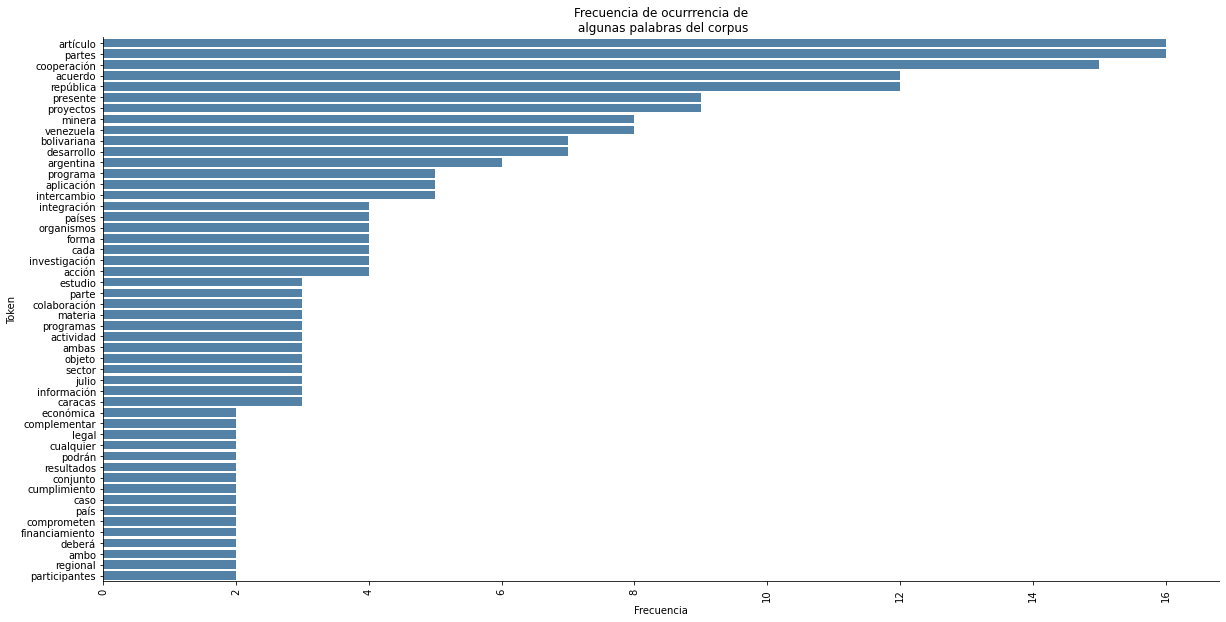

In [28]:
plt.figure(figsize=(20,10))
seaborn.barplot(y=df_tokens[:50].Token, x=df_tokens[:50].Frecuencia, color='steelblue')
plt.title('Frecuencia de ocurrrencia de\n algunas palabras del corpus')
plt.xticks(rotation=90)
seaborn.despine()

Graficamos lo mismo en una nube de palabras

In [29]:
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

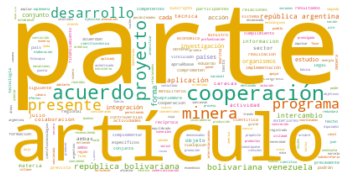

In [30]:
wc.generate(texto)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Las palabra que más se repiten, *parte* y *artículo*, no me dicen nada del documento. Pero hay otras con menor frecuencia, *acuerdo, cooperación, minera* que sí le dan sentido al documento, es un **acuerdo de cooperación minera**.

También observamos que existen palabras que van juntas, como por ejemplo *república bolivariana* y *república argentina*, por lo que pueden ser tomadas como una sola. Incluso las palabras *república bolivariana venezuela* puede ser tomada como una sola palabra.

Esto nos lleva a analizar los N-Gramas para obtener las palabras relevantes.

# Palabras relevantes

Calcularemos TF-IDF (Term Frecuency-Inverse Document Frecuency) para obtener las palabras más relevante de cada documento.

El cálculo lo haremos sobre los textos ya normalizados, por lo que agregamos una columna al DataFrame con el texto normalizado de cada documento.

In [31]:
sw = nltk.corpus.stopwords.words('spanish')
df_corpus["TEXTO_NORM"] = df_corpus["TEXTO"].apply(lambda x: normalize_texto(x, sw))
df_corpus.head()

,ID,FILE,TEXTO,TEXTO_NORM
0,0,../Datos/Infoleg/100016.txt,ACUERDOS\nLey 25.939\nApruébase el Acuerdo Sob...,acuerdos apruébase acuerdo cooperación minera ...
1,1,../Datos/Infoleg/100025.txt,MINISTERIO DE ECONOMIA Y PRODUCCION\nDecisión ...,ministerio economia produccion decisión admini...
2,2,../Datos/Infoleg/100026.txt,Secretaría de Hacienda\nPRESUPUESTO\nResolució...,secretaría hacienda presupuesto resolución mod...
3,3,../Datos/Infoleg/100027.txt,Ministerio de Economía y Producción\nREGIMEN S...,ministerio economía producción regimen simplif...
4,4,../Datos/Infoleg/100028.txt,Secretaría de Empleo\nPROGRAMA JEFES DE HOGAR\...,secretaría empleo programa jefes hogar resoluc...


Agregamos una columna con la cantidad de palabras en cada texto normalizado. Esto nos servirá para luego poder compararla con la cantidad de palabras más relevantes de cada documento

In [32]:
df_corpus["CANT_PALABRAS"] = df_corpus["TEXTO_NORM"].apply(lambda x: len(x))
df_corpus.head()

,ID,FILE,TEXTO,TEXTO_NORM,CANT_PALABRAS
0,0,../Datos/Infoleg/100016.txt,ACUERDOS\nLey 25.939\nApruébase el Acuerdo Sob...,acuerdos apruébase acuerdo cooperación minera ...,5815
1,1,../Datos/Infoleg/100025.txt,MINISTERIO DE ECONOMIA Y PRODUCCION\nDecisión ...,ministerio economia produccion decisión admini...,577
2,2,../Datos/Infoleg/100026.txt,Secretaría de Hacienda\nPRESUPUESTO\nResolució...,secretaría hacienda presupuesto resolución mod...,1794
3,3,../Datos/Infoleg/100027.txt,Ministerio de Economía y Producción\nREGIMEN S...,ministerio economía producción regimen simplif...,1360
4,4,../Datos/Infoleg/100028.txt,Secretaría de Empleo\nPROGRAMA JEFES DE HOGAR\...,secretaría empleo programa jefes hogar resoluc...,6177


In [33]:
print(f'Los documentos tienen una media de {int(df_corpus["CANT_PALABRAS"].mean())} palabras.' )

Los documentos tienen una media de 6316 palabras.


Generamos el vocabulario a partir del texto normalizado. En dicho vocabulario incluiremos bi-gramas para mejorar el análisis.

In [34]:
cv_vectorizer = CountVectorizer(ngram_range=(1,2))
word_count_vector = cv_vectorizer.fit_transform(df_corpus['TEXTO_NORM'])

In [35]:
print(f'La cantidad de términos en nuestro vocabulario es de {word_count_vector.shape[1]} palabras')

La cantidad de términos en nuestro vocabulario es de 683250 palabras


Mostramos 10 palabras de nuestro diccionario

In [36]:
list(cv_vectorizer.vocabulary_.keys())[:10]

['acuerdos',
 'apruébase',
 'acuerdo',
 'cooperación',
 'minera',
 'suscripto',
 'caracas',
 'julio',
 'república',
 'bolivariana']

Calculamos la Frecuencia Inversa del Documento (IDF) a partir del la matriz de generada anteriormente.

In [37]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

Mostramos los valores IDF de nuestro diccionario.

In [38]:
# print idf values 
df_idf = pandas.DataFrame(tfidf_transformer.idf_, index=cv_vectorizer.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
nacional,1.176183
artículo,1.195928
oficial,1.243746
registro,1.263845
archívese,1.284887
...,...
establecimiento instalaciones,8.131299
establecimiento instituirá,8.131299
establecimiento instrucciones,8.131299
establecimiento inferior,8.131299


Observamos que las palabras "nacional", "artículo", "oficial", "registro", "archívese", tienen los valores de IDF más bajos. Esto lógico, ya que estas palabras aparecen en todos y cada uno de los documentos de nuestra colección. Cuanto menor sea el valor IDF de una palabra, menos exclusiva será para un documento en particular.

Mas adelante utilizaremos esta matriz para ampliar el listado de stop words.

Ahora calculamos el TF-IDF de cada una de las palabras de nuestro diccionario. 

In [39]:
tf_idf_vector = tfidf_transformer.transform(word_count_vector)

Mostramos los valores TF-IDF del primer documento.

In [40]:
feature_names = cv_vectorizer.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pandas.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False).head(10)

,tfidf
cooperación,0.243878
venezuela,0.201341
minera,0.185912
bolivariana,0.184903
república bolivariana,0.184903
bolivariana venezuela,0.184903
partes,0.146706
proyectos,0.130848
república,0.100326
programa acción,0.090767


Observamos que las palabras *cooperación*, *venezuela* y *minera* son las más relevantes, lo cual es lo que esperábamos, ya que el documento trata de un *acuerdo de cooperación minera con Venezuela*.

También observamos que obtienen el mismo valor TF-IDF [república bolivarioana] y [bolivariana venezuela], lo cual tiene mucho sentido.

Generamos una función que nos retorne las 10 palabras mas relevantes de un documento, para luego poder luego agregar una columna al data frame con dichas palabras.

In [41]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [42]:
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 6))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [43]:
def get_top_n(texto_id, top_n):
    document_vector = tf_idf_vector[texto_id]
    
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(document_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items, top_n)
    
    return keywords

Probamos la función con el primer documento.

In [44]:
print(get_top_n(0, 10).keys())

dict_keys(['cooperación', 'venezuela', 'minera', 'república bolivariana', 'bolivariana venezuela', 'bolivariana', 'partes', 'proyectos', 'república', 'programa acción'])


# Ampliamos el listado de stop words

La frecuencia inversa de documentos (IDF) es un peso que indica la frecuencia con la que se usa una palabra. Cuanto más frecuente sea su uso en documentos, menor será su puntuación. Cuanto menor sea la puntuación, menos importante se vuelve la palabra.

Ampliaremos el listado de stop words con palabras que tengan peso menor a 5.

In [45]:
df_idf_sort = df_idf.sort_values(by=['idf_weights'])
df_idf_sort.index[df_idf_sort.idf_weights < 5]

Index(['nacional', 'artículo', 'oficial', 'registro', 'archívese', 'visto',
       'comuníquese', 'nacional registro', 'registro oficial', 'presente',
       ...
       'expte número', 'demás condiciones', 'presentó', 'metro', 'especies',
       'siguientes requisitos', 'arbitrar', 'indemnizaciones', 'rendimiento',
       'margen'],
      dtype='object', length=4539)

In [46]:
# Agregamos stopwords
stop_words = nltk.corpus.stopwords.words('spanish')
for word in df_idf_sort.index[df_idf_sort.idf_weights < 5]:
    stop_words.append(word)
print(f'Cantidad de palabras en la lista de stop_words: {len(stop_words)}')

Cantidad de palabras en la lista de stop_words: 4852


Volvemos a normalizar el texto del primer documento ulizando el nuevo listado de stop_words.

In [47]:
texto = normalize_texto(df_corpus[0:1].TEXTO[0], stop_words)
print('Cantidad de tokens:', len(texto.split()))

Cantidad de tokens: 139


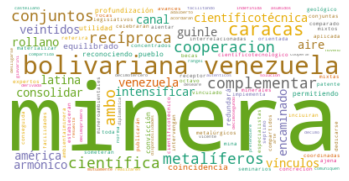

In [48]:
wc.generate(texto)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Ahora si vemos palabras más relevantes.

# Unificamos

Normalizamos de nuevo todos los documentos, para que aplique el nuevo listado de stop words.

In [49]:
df_corpus["TEXTO_NORM_2"] = df_corpus["TEXTO"].apply(lambda x: normalize_texto(x, stop_words))

In [50]:
df_corpus["CANT_PALABRAS_2"] = df_corpus["TEXTO_NORM_2"].apply(lambda x: len(x))
df_corpus[['CANT_PALABRAS', 'TEXTO_NORM_2', 'CANT_PALABRAS_2']].head()

,CANT_PALABRAS,TEXTO_NORM_2,CANT_PALABRAS_2
0,5815,minera caracas bolivariana venezuela científic...,1421
1,577,suprema generan expropiación lavalle aire aire,46
2,1794,tesorería remanentes remanentes tesoreria rema...,146
3,1360,simplificado pequeños reintegros restitución r...,239
4,6177,hogar circuito componente interinstitucional r...,1193


In [51]:
print(f'Los documentos tienen una media de {int(df_corpus["CANT_PALABRAS_2"].mean())} palabras, sustancialmente menor a los {int(df_corpus["CANT_PALABRAS"].mean())} anteriores.' )

Los documentos tienen una media de 1413 palabras, sustancialmente menor a los 6316 anteriores.


Como nuestro diccionario se obtiene a partir del texto normalizado, volvemos a vectorizar utilizando la columna *TEXTO_NORM_2*

In [52]:
word_count_vector = cv_vectorizer.fit_transform(df_corpus['TEXTO_NORM_2'])

Calculamos la Frecuencia Inversa del Documento (IDF) a partir del la matriz de generada anteriormente.

In [53]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

Veamos los nuevos valores de IDF:

In [54]:
# print idf values 
df_idf = pandas.DataFrame(tfidf_transformer.idf_, index=cv_vectorizer.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
norma,1.923715
dictum,1.944062
aire,1.963782
fine,2.555350
peso,2.636182
...,...
encuadrada dada,8.131299
encuadrada generado,8.131299
encuadrada informatizada,8.131299
encuadramiento libros,8.131299


Calculamos TF-IDF de cada una de las palabras del nuevo diccionario.

In [55]:
tf_idf_vector = tfidf_transformer.transform(word_count_vector)

Observamos los valores de TF-IDF del primer documento para ver si hubo alguna modificiación.

In [56]:
feature_names = cv_vectorizer.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pandas.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False).head(10)

,tfidf
venezuela,0.337258
minera,0.311413
bolivariana venezuela,0.309724
bolivariana,0.309724
caracas,0.146379
metalíferos,0.106680
minera bolivariana,0.106680
cooperacion minera,0.106680
caracas bolivariana,0.101361
cooperacion,0.073029


Como esperamos, las palabras más relevantes son *venezuela* y *minera*.

# Variable objetivo

Propondremos 2 opciones para generar una columna que clasifique los documentos:

* La palabra con más peso del documento
* El organismo al que hace referencia el texto

### Palabra con más peso del documento


Agrego una columna con las 10 palabras más frecuentes de cada documento.

In [57]:
df_corpus["TOP_10"] = df_corpus["ID"].apply(lambda x: ' '.join(list(get_top_n(x, 10).keys())))

In [58]:
df_corpus[['CANT_PALABRAS', 'TEXTO_NORM_2', 'CANT_PALABRAS_2', 'TOP_10']].head()

,CANT_PALABRAS,TEXTO_NORM_2,CANT_PALABRAS_2,TOP_10
0,5815,minera caracas bolivariana venezuela científic...,1421,venezuela minera bolivariana venezuela bolivar...
1,577,suprema generan expropiación lavalle aire aire,46,suprema generan generan expropiación expropiac...
2,1794,tesorería remanentes remanentes tesoreria rema...,146,remanentes tesoreria remanentes tesoreria vein...
3,1360,simplificado pequeños reintegros restitución r...,239,reintegros restitución tarjeta magnética reint...
4,6177,hogar circuito componente interinstitucional r...,1193,componente hogar uocra componente hogar gecal ...


Genero una nube de palabras del documentos normalizados

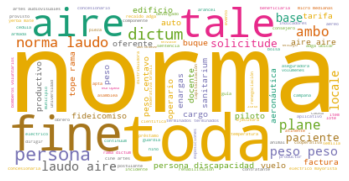

In [59]:
wc.generate(' '.join(df_corpus['TEXTO_NORM_2']))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Genero una nube de palabras con las incluidas en la columna TOP_10

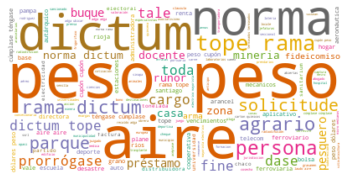

In [60]:
wc.generate(' '.join(df_corpus['TOP_10']))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

No encontramos palabras que representen temas que nos permitan clasificar objetivamente un documento.

Agregamos una columna donde almacenaremos una palabra que represente el documento. Sabiendo que es un criterio muy arbitrario y sin fundamento, le colocaremos la palabra más frecuente.

In [61]:
df_corpus["TOP_1"] = df_corpus["ID"].apply(lambda x: ' '.join(list(get_top_n(x, 1).keys())))

In [62]:
df_corpus[['CANT_PALABRAS', 'TOP_10', 'TOP_1']].head()

,CANT_PALABRAS,TOP_10,TOP_1
0,5815,venezuela minera bolivariana venezuela bolivar...,venezuela
1,577,suprema generan generan expropiación expropiac...,suprema generan
2,1794,remanentes tesoreria remanentes tesoreria vein...,remanentes
3,1360,reintegros restitución tarjeta magnética reint...,reintegros
4,6177,componente hogar uocra componente hogar gecal ...,componente


### El organismo al que hace referencia el texto

Analizando el comienzo de cada texto se observó que en el primer renglón hacía referencia a un ministerio, secretaría o apareciían algunas expresiones que se repetían.
Decidimos intentar usar esas expresiones para definir las clases a utilizar.

A continuación se presenta el clasificador:

In [63]:
def clasificacion_manual(texto):
    
    clase = "Sin clase"
    
    if "MINISTERIO DE ECONOMIA" in texto or "COMISION NACIONAL DE VALORES" in texto or "Secretaría de Hacienda" in texto: 
        clase = "MINISTERIO DE ECONOMIA"

    if "BANCO CENTRAL DE LA REPUBLICA ARGENTINA" in texto or "ADMINISTRACION FEDERAL DE INGRESOS PUBLICOS" in texto or "SUPERINTENDENCIA DE ADMINISTRADORAS DE FONDOS" in texto or "nstituto Nacional de Asociativismo y Economía" in texto: 
        clase = "MINISTERIO DE ECONOMIA"

    if "MINISTERIO DE TRABAJO" in texto or "Secretaría de Empleo" in texto or "Subsecretaría de la Pequeña y Mediana Empresa" in texto: 
        clase = "MINISTERIO DE TRABAJO"

    if "SISTEMA INTEGRADO DE JUBILACIONES Y PENSIONES" in texto or "Comisión Nacional de Trabajo Agrario" in texto: 
        clase = "MINISTERIO DE TRABAJO"
        
    if "Superintendencia de Riesgos del Trabajo" in texto or "Administración de Programas Especiales" in texto: 
        clase = "MINISTERIO DE TRABAJO"

    if "ADMINISTRACION NACIONAL DE LA SEGURIDAD SOCIAL" in texto or "JUBILACIONES" in texto or "Secretaría de Seguridad Social" in texto: 
        clase = "MINISTERIO DE TRABAJO"

    if "MINISTERIO DEL INTERIOR" in texto or "Dirección de Tránsito Aéreo" in texto or "DIRECCION NACIONAL DE MIGRACIONES" in texto: 
        clase = "MINISTERIO DEL INTERIOR"

    if "MINISTERIO DE RELACIONES EXTERIORES" in texto or "Ministerio de Relaciones Exteriores" in texto: 
        clase = "MINISTERIO DE RELACIONES EXTERIORES"

    if "Secretaría de Agricultura, Ganadería, Pesca" in texto: 
        clase = "MINISTERIO DE AGRICULTURA, GANADERÍA y PESCA + AMBIENTE"

    if "ADMINISTRACION DE PARQUES NACIONALES" in texto: 
        clase = "MINISTERIO DE AGRICULTURA, GANADERÍA y PESCA + AMBIENTE"
        
    if "PRESIDENCIA DE LA NACION" in texto: 
        clase = "PRESIDENCIA DE LA NACION"

    if "MINISTERIO DE PLANIFICACION" in texto or "Comité Federal de Radiodifusión" in texto or "ENTE NACIONAL REGULADOR DE LA ELECTRICIDAD" in texto: 
        clase = "MINISTERIO DE PLANIFICACION FEDERAL"

    if "MINISTERIO DE SALUD" in texto or " Superintendencia de Servicios de Salud" in texto or "Administración Nacional de Medicamentos Alimentos y Tecnología Médica" in texto: 
        clase = "MINISTERIO DE SALUD"

    if "SUPERINTENDENCIA DE SERVICIOS DE SALUD" in texto or "Superintendencia de Servicios de Salud" in texto or "Administración Nacional de Medicamentos" in texto: 
        clase = "MINISTERIO DE SALUD"

    if "Ministerio de Justicia y Derechos Humanos" in texto or "MINISTERIO DE JUSTICIA" in texto or "DERECHOS DEL NIÑO" in texto: 
        clase = "MINISTERIO DE JUSTICA"

    if "Ministerio de Defensa" in texto or "MINISTERIO DE DEFENSA" in texto: 
        clase = "MINISTERIO DE DEFENSA + SEGURIDAD"

    if "JUSTICIA MILITAR" in texto or "ARMAS QUIMICAS" in texto or "REGISTRO NACIONAL DE ARMAS DE FUEGO" in texto or "INGRESO DE TROPAS EXTRANJERAS" in texto: 
        clase = "MINISTERIO DE DEFENSA + SEGURIDAD"

    if "POLICIA FEDERAL ARGENTINA" in texto or "Superintendencia de Seguros de la Nación" in texto: 
        clase = "MINISTERIO DE DEFENSA + SEGURIDAD"

    if "MINISTERIO DE DESARROLLO SOCIAL" in texto: 
        clase = "MINISTERIO DE DESARROLLO SOCIAL"

    if "Secretaría de Ciencia, Tecnología e Innovación" in texto or "AUTORIDAD REGULATORIA NUCLEAR" in texto: 
        clase = "MINISTERIO DE EDUCACIÓN, CIENCIA y TECNOLOGÍA + CULTURA"

    if "CONSEJO NACIONAL DE INVESTIGACIONES CIENTIFICA" in texto or "Ministerio de Educación, Ciencia y Tecnología" in texto: 
        clase = "MINISTERIO DE EDUCACIÓN, CIENCIA y TECNOLOGÍA + CULTURA"
        
    if "Consejo Gremial de Enseñanza Privada" in texto or "DEPORTE" in texto: 
        clase = "MINISTERIO DE EDUCACIÓN, CIENCIA y TECNOLOGÍA + CULTURA"

    if "INSTITUTO NACIONAL DE CINE Y ARTES AUDIOVISUAL" in texto: 
        clase = "MINISTERIO DE EDUCACIÓN, CIENCIA y TECNOLOGÍA + CULTURA"

    if "COMISION NACIONAL DE COMUNICACIONES" in texto: 
        clase = "MINISTERIO DE COMUNICACIONES"

    if "Apruébase el Acuerdo" in texto or "Apruébase el Convenio" in texto or "Apruébase el Tratado" in texto: 
        clase = "ACUERDOS, TRATADOS y CONVENIOS"

    return clase

Aplicamos el clasificador al texto original.

El clasificador se realizó a mano, analizando la priemra línea de cada documento intenando hacer asociaciones a partir de esto.

In [64]:
df_corpus["ORGANISMO"] = df_corpus["TEXTO"].apply(lambda x: clasificacion_manual(x))

In [65]:
df_corpus[["TEXTO", "ORGANISMO"]].head()

,TEXTO,ORGANISMO
0,ACUERDOS\nLey 25.939\nApruébase el Acuerdo Sob...,"ACUERDOS, TRATADOS y CONVENIOS"
1,MINISTERIO DE ECONOMIA Y PRODUCCION\nDecisión ...,MINISTERIO DE ECONOMIA
2,Secretaría de Hacienda\nPRESUPUESTO\nResolució...,MINISTERIO DE ECONOMIA
3,Ministerio de Economía y Producción\nREGIMEN S...,MINISTERIO DE ECONOMIA
4,Secretaría de Empleo\nPROGRAMA JEFES DE HOGAR\...,MINISTERIO DE TRABAJO


# Modelos de predicción

Para resolver este problema de clasificación entrenaremos el modelo de clasificación lineal Regresion Logística.

De la librería scikit-learn utilizaremos las siguientes:
* LogisticRegretion
* SGDClassifier

A partir del documento normalizado TEXTO_NORM_2 trataremos de predecir la clasificación del mismo según las 2 columnas definidas como objetivo por separado.

Al tener muchas clases sólo vamos a considerar la Accuracy como medida de evaluación.

In [66]:
import warnings

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")


### Palabra con más peso del documento

Observemos que tan desvalanceadas están las clases

In [67]:
df_corpus['TOP_1'].value_counts()

peso                         51
aire                         20
camex                        17
                             16
peso cupón                   14
                             ..
deportivas futbol             1
modernizacion                 1
tucumán                       1
prescrito                     1
constructores consultoras     1
Name: TOP_1, Length: 1719, dtype: int64

Tenemos 1719 clases para 2500 documentos. Son demasiadas clases.

Vectorizamos el texto

In [68]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(df_corpus['TEXTO_NORM_2'])

<2500x39739 sparse matrix of type '<class 'numpy.float64'>'
	with 205589 stored elements in Compressed Sparse Row format>

Dividimos los datos en entrenamiento y validación con un procentaje de 70% para entrenamiento y 30% para validación con shuffle, seleccionar las features X e Y

In [69]:
# División entre instancias vectorizadas y etiquetas
X, y = vectorizer.transform(df_corpus["TEXTO_NORM_2"]), df_corpus["TOP_1"]

In [70]:
# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

#### a) Modelo de Regresión Logística

Utilizaremos los siquientes hiperparámetros:
* multi_class: one-vs-rest (OVR) y multinomial (la pérdida minimizada es el ajuste de pérdida multinomial en toda la distribución de probabilidad)
* penalty: L1. Recorta los pesos de las características no informativas a cero. Nuestro caso es extraer el vocabulario fuertemente discriminativo de cada clase. 

In [71]:
param_grid = {
    'multi_class': ['ovr', 'multinomial'],
    'max_iter': [1, 2, 4]
}

In [72]:
model = LogisticRegression(penalty='l1', solver='saga', random_state=0)

In [73]:
cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)
cv.fit(X_train, y_train)

C:\Users\jperezv\Anaconda3\envs\mentoria\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=3,
             estimator=LogisticRegression(penalty='l1', random_state=0,
                                          solver='saga'),
             param_grid={'max_iter': [1, 2, 4],
                         'multi_class': ['ovr', 'multinomial']},
             scoring='accuracy')

Observamos los resultados ordenados por ranking

In [74]:
results = cv.cv_results_

In [75]:
df_results = pandas.DataFrame(results)
df_results[['param_multi_class', 'param_max_iter', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=["rank_test_score"])

,param_multi_class,param_max_iter,mean_test_score,std_test_score,rank_test_score
4,ovr,4,0.197134,0.015026,1
2,ovr,2,0.190286,0.008404,2
5,multinomial,4,0.181710,0.006273,3
3,multinomial,2,0.171998,0.008954,4
0,ovr,1,0.150281,0.011675,5
1,multinomial,1,0.127997,0.008032,6


Realizaremos las predicciones con el modelo mejor rankeado.

In [76]:
best_model = cv.best_estimator_

In [77]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)    

In [78]:
accuracy = metrics.accuracy_score(y_test, y_test_pred)
print(f'Accuracy:{accuracy:{0.2}}')

Accuracy:0.21


Vemos que el Accuracy es muy bajo, solo un 21%. Esto significa que no puede clasificar correctamente los documentos. Evidentemente esto es debido a la mala selección de las clases.

#### b) Modelo SGDClassifier

In [79]:
param_grid = {
    'loss': [
        'hinge',        # SVM
        'log',          # logistic regression
    ],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

In [80]:
model = SGDClassifier(random_state=0)

In [81]:
cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)
cv.fit(X_train, y_train)

C:\Users\jperezv\Anaconda3\envs\mentoria\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=3, estimator=SGDClassifier(random_state=0),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log']},
             scoring='accuracy')

In [82]:
results = cv.cv_results_

In [83]:
df_results = pandas.DataFrame(results)
df_results[['param_loss', 'param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=["rank_test_score"])

,param_loss,param_alpha,mean_test_score,std_test_score,rank_test_score
1,log,0.0001,0.329132,0.015163,1
0,hinge,0.0001,0.326280,0.006928,2
4,hinge,0.01,0.321704,0.014478,3
2,hinge,0.001,0.320564,0.012633,4
3,log,0.001,0.302276,0.013085,5
6,hinge,0.1,0.237702,0.015160,6
5,log,0.01,0.230847,0.012820,7
7,log,0.1,0.129139,0.004394,8


Realizaremos las predicciones con el modelo mejor rankeado.

In [84]:
best_model = cv.best_estimator_

In [85]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)    

In [86]:
accuracy = metrics.accuracy_score(y_test, y_test_pred)
print(f'Accuracy:{accuracy:{0.2}}')

Accuracy:0.32


Observamos una mejora en el Accuracy, 32%, respecto al 21% del modelo anterior, pero sigue siendo bajo. 

### En función del Organismo al que hace referencia el texto

Observemos que tan desvalanceadas están las clases

In [87]:
df_corpus["ORGANISMO"].value_counts()

MINISTERIO DE ECONOMIA                                     807
MINISTERIO DE TRABAJO                                      579
Sin clase                                                  353
MINISTERIO DE PLANIFICACION FEDERAL                        165
MINISTERIO DE SALUD                                        100
PRESIDENCIA DE LA NACION                                    82
MINISTERIO DE DEFENSA + SEGURIDAD                           78
MINISTERIO DE AGRICULTURA, GANADERÍA y PESCA + AMBIENTE     67
MINISTERIO DE EDUCACIÓN, CIENCIA y TECNOLOGÍA + CULTURA     57
MINISTERIO DEL INTERIOR                                     47
MINISTERIO DE JUSTICA                                       47
MINISTERIO DE RELACIONES EXTERIORES                         39
MINISTERIO DE DESARROLLO SOCIAL                             31
ACUERDOS, TRATADOS y CONVENIOS                              28
MINISTERIO DE COMUNICACIONES                                20
Name: ORGANISMO, dtype: int64

Se observa que 353 documentos quedaron sin clasificar, a estos los vamos a considerar outliers y los eliminamos del conjunto de entrenamiento y validación.

Eliminamos los documentos sin clasificar:

In [88]:
df_corpus_2 = df_corpus[df_corpus["ORGANISMO"] != "Sin clase"]

Vectorizamos el texto

In [89]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(df_corpus_2['TEXTO_NORM_2'])

<2147x37529 sparse matrix of type '<class 'numpy.float64'>'
	with 184616 stored elements in Compressed Sparse Row format>

Dividimos los datos en entrenamiento y validación:

In [90]:
# División entre instancias vectorizadas y etiquetas
X, y = vectorizer.transform(df_corpus_2["TEXTO_NORM_2"]), df_corpus_2["ORGANISMO"]

from sklearn.model_selection import train_test_split, GridSearchCV
# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

#### a) Modelo de Regresión Logística

In [91]:
param_grid = {
    'multi_class': ['ovr', 'multinomial'],
    'max_iter': [1, 2, 4]
}

In [92]:
model = LogisticRegression(penalty='l1', solver='saga', random_state=0)

In [93]:
cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(penalty='l1', random_state=0,
                                          solver='saga'),
             param_grid={'max_iter': [1, 2, 4],
                         'multi_class': ['ovr', 'multinomial']},
             scoring='accuracy')

Observamos los resultados ordenados por ranking

In [94]:
results = cv.cv_results_

In [95]:
df_results = pandas.DataFrame(results)
df_results[['param_multi_class', 'param_max_iter', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=["rank_test_score"])

,param_multi_class,param_max_iter,mean_test_score,std_test_score,rank_test_score
3,multinomial,2,0.601851,0.016655,1
5,multinomial,4,0.598552,0.020881,2
4,ovr,4,0.588560,0.012987,3
2,ovr,2,0.588526,0.026007,4
1,multinomial,1,0.541206,0.077739,5
0,ovr,1,0.529894,0.071425,6


Realizaremos las predicciones con el modelo mejor rankeado.

In [96]:
best_model = cv.best_estimator_

In [97]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)    

In [98]:
accuracy = metrics.accuracy_score(y_test, y_test_pred)
print(f'Accuracy:{accuracy:{0.2}}')

Accuracy:0.61


Según la Acurracy el 61% fue bien clasificado, el resultado es mucho más alto y razonable que en el caso anterior, sin embargo hay un 39% que sigue estando mal clasificado, esto se debe a que no estamos usando el método apropiado para generar la clasificación inicial (fue hecho a mano por personas que no son exertas de dominio), en estos caso que no tenemos definida la clase es necesario usar metodos de aprendizaje no supervisado.

#### b) Modelo SGDClassifier

In [99]:
param_grid = {
    'loss': [
        'hinge',        # SVM
        'log',          # logistic regression
    ],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

In [100]:
model = SGDClassifier(random_state=0)

In [101]:
cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SGDClassifier(random_state=0),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log']},
             scoring='accuracy')

In [102]:
results = cv.cv_results_

In [103]:
df_results = pandas.DataFrame(results)
df_results[['param_loss', 'param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=["rank_test_score"])

,param_loss,param_alpha,mean_test_score,std_test_score,rank_test_score
0,hinge,0.0001,0.758322,0.008152,1
2,hinge,0.001,0.744347,0.007250,2
1,log,0.0001,0.723707,0.006353,3
4,hinge,0.01,0.694399,0.008768,4
3,log,0.001,0.622512,0.009846,5
5,log,0.01,0.498661,0.011712,6
7,log,0.1,0.432060,0.033573,7
6,hinge,0.1,0.406776,0.016289,8


Realizaremos las predicciones con el modelo mejor rankeado.

In [104]:
best_model = cv.best_estimator_

In [105]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)    

In [106]:
accuracy = metrics.accuracy_score(y_test, y_test_pred)
print(f'Accuracy:{accuracy:{0.2}}')

Accuracy:0.78


El mejor resultabo obtenido .... 

# Conclusión

No logramos generar una clasificación que nos indique de qué trata cada documento. 

El modelo SGDClassifier obtuvo los mejores resultados en ambos criterios de clasificación.